In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import shape
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Read In Geocode Output File and Convert To Geopandas Dataframe

In [2]:
geocode_output = pd.read_excel('data/geocode_output.xlsx', index_col=0) #First have to read in as a pandas 

CRS = "EPSG:4326" #Set the geodataframes to a consistent coordinate reference system

#Create a geodataframe from the output using the points_from_xy command

apps_gdf = gpd.GeoDataFrame(geocode_output, geometry=gpd.points_from_xy(geocode_output.Longitude, geocode_output.Latitude))

apps_gdf.crs = CRS  

apps_gdf

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685)
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465)
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210)
6,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367)
9,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517)
...,...,...,...,...,...,...,...,...,...
2937,Approved,1,0,0,1,0,43.708080,-79.311072,POINT (-79.31107 43.70808)
2938,Approved,1,0,0,0,1,43.615174,-79.529775,POINT (-79.52977 43.61517)
2939,Approved,1,0,0,0,1,43.770740,-79.543612,POINT (-79.54361 43.77074)
2940,Denied,1,0,1,0,0,43.741098,-79.402167,POINT (-79.40217 43.74110)


## Set Functions

In [3]:
API_URL = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action"

In [4]:
#Function to retrieve data from Toronto Open Data API

def get_package_tables(package_id_or_name):
    params = { "id": package_id_or_name}
    package = requests.get(f"{API_URL}/package_show", params).json()
    tables=[]
    
    for idx, resource in enumerate(package["result"]["resources"]):
        if resource["datastore_active"]:
            url = f"{API_URL}/datastore_search"
            p = {"id": resource["id"]}
            total_record_count = requests.get(url, {"id": resource["id"] }).json()["result"]["total"]
            p["limit"] = total_record_count
            
            data = requests.get(url, p).json()
            df = pd.DataFrame(data["result"]["records"])
            tables.append(df)
    return tables


#Function to parse the string from the geometry columns in a pandas dataframe. This will allow for the conversion into a geopandas dataframe

def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None
    
    

#Function to convert pandas dataframe to geopandas dataframe with a consistent coordinate reference system

def convert_to_gdf(dataframe):
    converted_gdf = gpd.GeoDataFrame(dataframe, geometry="geometry")
    converted_gdf.crs = CRS
    return converted_gdf


    
# Remove columns that are not area name or geometry from geopandas dataframe

def remove_geo_columns(geo_dataframe):
    final_table_columns = ['AREA_NAME', 'geometry']
    geo_df_with_cols_removed = geo_dataframe.drop(columns=[col for col in geo_dataframe if col not in final_table_columns])
    return geo_df_with_cols_removed


# Drops all columns but the geometry column. This is used for datasets where you want to return a boolean value. 

def geo_column_only(geo_dataframe, col_name):
    final_table_columns = ['geometry']
    geo_df_with_cols_removed = geo_dataframe.drop(columns=[col for col in geo_dataframe if col not in final_table_columns])
    geo_df_with_cols_removed[col_name] = 1
    return geo_df_with_cols_removed
    
    
    
#Function to perform a left spatial join on two geodataframes and drop the right_index column after the join has been performed

def join_reducer(left, right):
    sjoin = gpd.sjoin(left, right, how='left')
    sjoin.drop('index_right', axis=1, inplace=True)
    return sjoin

## 1. Community Council Boundaries

In [5]:
council_boundaries = get_package_tables("community-council-boundaries")
council_boundaries = council_boundaries[0]
council_boundaries.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,549,2476922,26002906,None,EA,EA,Scarborough Community Council,Scarborough Community Council,None,None,None,None,17503889,3.616463e+08,99909.825113,"{""type"": ""Polygon"", ""coordinates"": [[[-79.1517..."
1,550,2476921,26002905,None,SO,SO,Toronto and East York Community Council,Toronto and East York Community Council,None,None,None,None,17503905,2.243080e+08,127947.223220,"{""type"": ""Polygon"", ""coordinates"": [[[-79.2986..."
2,551,2476920,26002904,None,NO,NO,North York Community Council,North York Community Council,None,None,None,None,17503921,2.980871e+08,82762.050989,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3132..."
3,552,2476919,26002903,None,WE,WE,Etobicoke York Community Council,Etobicoke York Community Council,None,None,None,None,17503937,3.471409e+08,124437.576898,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4884..."


In [6]:
#Parse the string from the geometry column
council_boundaries["geometry"] = council_boundaries["geometry"].apply(parse_geom)

#Convert the dataframe to a geopandas dataframe
council_boundaries_gdf = convert_to_gdf(council_boundaries)

#Drop unwanted columns
council_boundaries_gdf = remove_geo_columns(council_boundaries_gdf)

council_boundaries_gdf.head()

,AREA_NAME,geometry
0,Scarborough Community Council,"POLYGON ((-79.15179 43.81409, -79.15174 43.813..."
1,Toronto and East York Community Council,"POLYGON ((-79.29864 43.71515, -79.29837 43.714..."
2,North York Community Council,"POLYGON ((-79.31326 43.75221, -79.31302 43.751..."
3,Etobicoke York Community Council,"POLYGON ((-79.48848 43.75333, -79.48834 43.752..."


<AxesSubplot:>

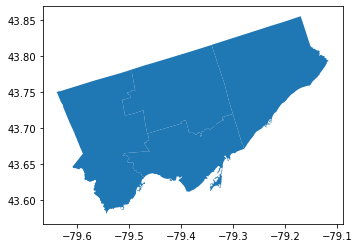

In [7]:
council_boundaries_gdf.plot()

In [8]:
#Rename the area name column to council

council_boundaries_gdf.rename(columns={'AREA_NAME': 'Council'}, inplace=True)

In [9]:
#Join councils to apps using the join_reducer function

gdf_1 = join_reducer(apps_gdf,council_boundaries_gdf)
gdf_1.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council
6,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council
9,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council


## 2. Neighbourhoods

In [10]:
neighbourhoods = get_package_tables("neighbourhoods")
neighbourhoods = neighbourhoods[0]
neighbourhoods.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry,CLASSIFICATION,CLASSIFICATION_CODE
0,11481,2480141,26005521,None,096,096,Casa Loma (96),Casa Loma (96),None,None,None,None,17545105,3.678385e+06,8214.176485,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4146...",None,None
1,11482,2480140,26005520,None,095,095,Annex (95),Annex (95),None,None,None,None,17545121,5.337192e+06,10513.883143,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3941...",None,None
2,11483,2480139,26005519,None,109,109,Caledonia-Fairbank (109),Caledonia-Fairbank (109),None,None,None,None,17545137,2.955857e+06,6849.911724,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4602...",None,None
3,11484,2480064,26005444,None,064,064,Woodbine Corridor (64),Woodbine Corridor (64),None,None,None,None,17545153,3.052518e+06,7512.966773,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3148...",None,None
4,11485,2480063,26005443,None,103,103,Lawrence Park South (103),Lawrence Park South (103),None,None,None,None,17545169,6.211341e+06,13530.370002,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4109...",None,None


In [11]:
#Parse the string from the geometry column
neighbourhoods["geometry"] = neighbourhoods["geometry"].apply(parse_geom)

#Convert the dataframe to a geopandas dataframe
neighbourhoods_gdf = convert_to_gdf(neighbourhoods)

#Drop unwanted columns
neighbourhoods_gdf = remove_geo_columns(neighbourhoods_gdf)

neighbourhoods_gdf.head()

,AREA_NAME,geometry
0,Casa Loma (96),"POLYGON ((-79.41469 43.67391, -79.41485 43.674..."
1,Annex (95),"POLYGON ((-79.39414 43.66872, -79.39588 43.668..."
2,Caledonia-Fairbank (109),"POLYGON ((-79.46021 43.68156, -79.46044 43.681..."
3,Woodbine Corridor (64),"POLYGON ((-79.31485 43.66674, -79.31660 43.666..."
4,Lawrence Park South (103),"POLYGON ((-79.41096 43.70408, -79.41165 43.703..."


In [12]:
#Get the neighbourhood number from area name

neighbourhoods_gdf['Neighbourhood_Number'] = neighbourhoods_gdf['AREA_NAME'].str.extract('.*\((.*)\).*')

#Remove the numbers from the area name

neighbourhoods_gdf['AREA_NAME'] = neighbourhoods_gdf['AREA_NAME'].str.replace(r"\(.*\)","")
neighbourhoods_gdf

,AREA_NAME,geometry,Neighbourhood_Number
0,Casa Loma,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96
1,Annex,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95
2,Caledonia-Fairbank,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109
3,Woodbine Corridor,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64
4,Lawrence Park South,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103
...,...,...,...
135,Dorset Park,"POLYGON ((-79.29443 43.77273, -79.29359 43.772...",126
136,Centennial Scarborough,"POLYGON ((-79.14511 43.76637, -79.14507 43.767...",133
137,Humbermede,"POLYGON ((-79.52628 43.73640, -79.52649 43.736...",22
138,Willowdale West,"POLYGON ((-79.44043 43.76340, -79.44052 43.763...",37


In [13]:
neighbourhoods_gdf.rename(columns={'AREA_NAME': 'Neighbourhood'}, inplace=True)

<AxesSubplot:>

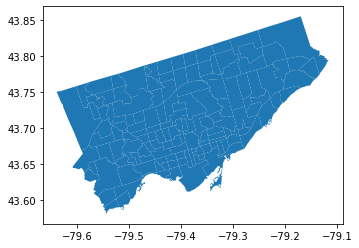

In [14]:
neighbourhoods_gdf.geometry.plot()

In [15]:
#Join councils to apps using the join_reducer function

gdf_2 = join_reducer(gdf_1, neighbourhoods_gdf)
gdf_2

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Neighbourhood_Number
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,16
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,95
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,14
6,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,45
9,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,42
...,...,...,...,...,...,...,...,...,...,...,...,...
2937,Approved,1,0,0,1,0,43.708080,-79.311072,POINT (-79.31107 43.70808),Toronto and East York Community Council,O'Connor-Parkview,54
2938,Approved,1,0,0,0,1,43.615174,-79.529775,POINT (-79.52977 43.61517),Etobicoke York Community Council,Alderwood,20
2939,Approved,1,0,0,0,1,43.770740,-79.543612,POINT (-79.54361 43.77074),Etobicoke York Community Council,Humber Summit,21
2940,Denied,1,0,1,0,0,43.741098,-79.402167,POINT (-79.40217 43.74110),North York Community Council,Bridle Path-Sunnybrook-York Mills,41


In [16]:
#Convert neighbourhood number to int

gdf_2['Neighbourhood_Number'] = gdf_2['Neighbourhood_Number'].astype(int)

## 3. Neighbourhood Profiles

In [17]:
neighbourhood_profiles = get_package_tables("neighbourhood-profiles")
neighbourhood_profiles = neighbourhood_profiles[0]
neighbourhood_profiles

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,n/a,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,n/a,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [18]:
#Filter down neighbourhood profiles to the rows of interst - population density, households in core housing need, average income

neighbourhood_profiles_filtered = neighbourhood_profiles.loc[[0,7,1682,2272]].copy()

#Drop columns that are no longer needed
neighbourhood_profiles_filtered = neighbourhood_profiles_filtered.drop(columns=['_id','Category','Topic','Data Source',
                                                                               'City of Toronto'])
#Transpose the rows and columns
neighbourhood_profiles_filtered = neighbourhood_profiles_filtered.T

#Set the column names to the first row
neighbourhood_profiles_filtered.columns = neighbourhood_profiles_filtered.iloc[0]

#Drop the second row

neighbourhood_profiles_filtered = neighbourhood_profiles_filtered.drop(neighbourhood_profiles_filtered.index[0])

neighbourhood_profiles_filtered

Characteristic,Neighbourhood Number,Population density per square kilometre,Number of households in core housing need,Total income: Average amount ($)
Agincourt North,129,"3,929","2,220","30,414"
Agincourt South-Malvern West,128,"3,034","1,795","31,825"
Alderwood,20,"2,435",540,"47,709"
Annex,95,"10,863","2,420","112,766"
Banbury-Don Mills,42,"2,775","2,115","67,757"
...,...,...,...,...
Wychwood,94,"8,541","1,280","54,460"
Yonge-Eglinton,100,"7,162",825,"89,330"
Yonge-St.Clair,97,"10,708","1,045","114,174"
York University Heights,27,"2,086","2,895","29,958"


In [20]:
neighbourhood_profiles_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Neighbourhood_Number             140 non-null    object
 1   Population_Density               140 non-null    object
 2   Households_In_Core_Housing_Need  140 non-null    object
 3   Average_Income                   140 non-null    object
dtypes: object(4)
memory usage: 5.5+ KB


In [21]:
#Convert columns to int

cols_to_int = ['Neighbourhood_Number','Population_Density','Households_In_Core_Housing_Need','Average_Income']

for col in neighbourhood_profiles_filtered.columns:
    
    neighbourhood_profiles_filtered[col] = neighbourhood_profiles_filtered[col].str.replace(',', '').astype(int)

neighbourhood_profiles_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Neighbourhood_Number             140 non-null    int32
 1   Population_Density               140 non-null    int32
 2   Households_In_Core_Housing_Need  140 non-null    int32
 3   Average_Income                   140 non-null    int32
dtypes: int32(4)
memory usage: 3.3+ KB


In [22]:
#Merge neighbourhood profiles to the geopandas dataframe

gdf_3 = gdf_2.merge(neighbourhood_profiles_filtered, how='left', on='Neighbourhood_Number')
gdf_3

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Neighbourhood_Number,Population_Density,Households_In_Core_Housing_Need,Average_Income
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,16,3199,1715,64140
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,95,10863,2420,112766
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,14,2712,3470,52787
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,45,4691,3255,42516
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,42,2775,2115,67757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,Approved,1,0,0,1,0,43.708080,-79.311072,POINT (-79.31107 43.70808),Toronto and East York Community Council,O'Connor-Parkview,54,3780,2035,43907
1537,Approved,1,0,0,0,1,43.615174,-79.529775,POINT (-79.52977 43.61517),Etobicoke York Community Council,Alderwood,20,2435,540,47709
1538,Approved,1,0,0,0,1,43.770740,-79.543612,POINT (-79.54361 43.77074),Etobicoke York Community Council,Humber Summit,21,1570,960,30731
1539,Denied,1,0,1,0,0,43.741098,-79.402167,POINT (-79.40217 43.74110),North York Community Council,Bridle Path-Sunnybrook-York Mills,41,1040,115,308010


In [23]:
#Drop Neighbourhood Number now that it is no longer required

gdf_3 = gdf_3.drop(columns = ['Neighbourhood_Number'])

## 4. Secondary Plan Areas

In [24]:
secondary_plans = get_package_tables("secondary-plans")
secondary_plans = secondary_plans[0]
secondary_plans.head()

,_id,OBJECTID,SECONDARY_PLAN_NUMBER,SECONDARY_PLAN_NAME,STATUS,X,Y,LONGITUDE,LATITUDE,Shape__Area,Shape__Length,geometry
0,2881,1,8,North York Centre,None,None,None,None,None,3.691954e+06,14959.123333,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4199..."
1,2882,2,10,York University,None,None,None,None,None,4.454946e+06,8560.781340,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4955..."
2,2883,3,26,Emery Village,None,None,None,None,None,1.197904e+06,6125.137530,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5426..."
3,2884,4,15,King-Parliament,None,None,None,None,None,2.038536e+06,6954.124124,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3565..."
4,2885,5,11,Motel Strip,None,None,None,None,None,4.510606e+05,3672.717621,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4778..."


In [25]:
#Parse the string from the geometry column
secondary_plans["geometry"] = secondary_plans["geometry"].apply(parse_geom)

#Convert the dataframe to a geopandas dataframe
secondary_plans_gdf = convert_to_gdf(secondary_plans)

#Keep geo column and create a secondary plan column
secondary_plans_gdf = geo_column_only(secondary_plans_gdf, 'Secondary_Plan')

secondary_plans_gdf.head()

,geometry,Secondary_Plan
0,"POLYGON ((-79.42000 43.78115, -79.41917 43.781...",1
1,"POLYGON ((-79.49552 43.78104, -79.49488 43.781...",1
2,"POLYGON ((-79.54263 43.74794, -79.54272 43.748...",1
3,"POLYGON ((-79.35653 43.65025, -79.35694 43.650...",1
4,"POLYGON ((-79.47784 43.62381, -79.47815 43.623...",1


<AxesSubplot:>

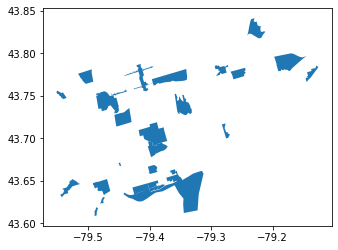

In [26]:
secondary_plans_gdf.plot()

In [27]:
#Spatil join the secondary plan areas, if the point is not in a secondary plan area set to 0

gdf_4 = join_reducer(gdf_3, secondary_plans_gdf)

gdf_4['Secondary_Plan'].fillna(0, inplace=True)

gdf_4.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0.0
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0.0
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0.0
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0.0
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1.0


## 5. Business Improvement Areas

In [28]:
business_improvement_areas = get_package_tables("business-improvement-areas")
business_improvement_areas = business_improvement_areas[0]
business_improvement_areas.head()

,_id,AREA_ID,DATE_EFFECTIVE,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,11006,2488485,2021-05-31T19:01:35,26010908,None,109-01,109-01,CityPlace and Fort York,CityPlace and Fort York,None,None,None,None,17633889,1.192955e+06,5327.234526,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4103..."
1,11007,2488484,2021-05-31T19:01:35,26010907,None,022-03,022-03,Mimico By The Lake,Mimico By The Lake,None,None,None,None,17633905,4.569793e+05,6461.469139,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4821..."
2,11008,2488483,2021-05-31T19:01:35,26010906,None,086-03,086-03,Dupont by the Castle,Dupont by the Castle,None,None,None,None,17633921,7.756085e+05,6898.748767,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4073..."
3,11009,2488482,2021-05-31T19:01:35,26010905,None,038-03,038-03,Rosedale Main Street,Rosedale Main Street,None,None,None,None,17633937,2.275580e+05,4852.934742,"{""type"": ""MultiPolygon"", ""coordinates"": [[[[-7..."
4,11010,2488481,2021-05-31T19:01:35,26010904,None,062-01,062-01,Albion Islington Square,Albion Islington Square,None,None,None,None,17633953,3.126040e+05,3979.632937,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5652..."


In [29]:
#Parse the string from the geometry column
business_improvement_areas["geometry"] = business_improvement_areas["geometry"].apply(parse_geom)

#Convert the dataframe to a geopandas dataframe
business_improvement_areas_gdf = convert_to_gdf(business_improvement_areas)

#Drop unwanted columns and add business improvement area identifier
business_improvement_areas_gdf = geo_column_only(business_improvement_areas_gdf, 'Business_Improvement_Area')

business_improvement_areas_gdf.head()

,geometry,Business_Improvement_Area
0,"POLYGON ((-79.41035 43.63815, -79.40898 43.638...",1
1,"POLYGON ((-79.48212 43.61830, -79.48253 43.617...",1
2,"POLYGON ((-79.40734 43.67893, -79.40704 43.678...",1
3,"MULTIPOLYGON (((-79.39043 43.68121, -79.39022 ...",1
4,"POLYGON ((-79.56524 43.73912, -79.56494 43.738...",1


<AxesSubplot:>

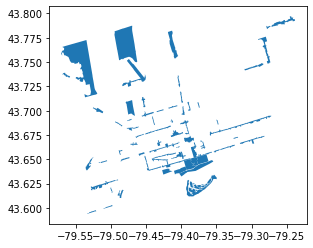

In [30]:
business_improvement_areas_gdf.plot()

In [31]:
gdf_5 = join_reducer(gdf_4, business_improvement_areas_gdf)

gdf_5['Business_Improvement_Area'].fillna(0, inplace=True)

gdf_5.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0.0,1.0
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0.0,0.0
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0.0,0.0
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0.0,0.0
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1.0,0.0


## 6. Site and Area Specific Policy

In [32]:
site_and_area_specific_policy = get_package_tables("site-and-area-specific-policies")
site_and_area_specific_policy = site_and_area_specific_policy[0]
site_and_area_specific_policy.head()

,_id,OBJECTID,SASP_NO,OPA_NO,MODIFICATION_NO,APPLICATION_NO,LOCATION,EFFECTIVE_YEAR,NOTES,X,Y,LONGITUDE,LATITUDE,Shape__Area,Shape__Length,geometry
0,84238,1614,002,None,None,None,"West Side of The West Mall, East of Etobicoke ...",None,None,None,None,None,None,9943.765625,448.185406,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5666..."
1,84239,1615,003,None,None,None,124 Belfield Road,None,None,None,None,None,None,19445.699219,642.859481,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5748..."
2,84240,1616,004,None,None,None,Monogram Place,None,None,None,None,None,None,65334.585938,1241.892825,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5562..."
3,84241,1617,005,None,None,None,20 Thompson Avenue,None,None,None,None,None,None,1461.867188,199.193983,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5143..."
4,84242,1618,006,None,None,None,"South Side of The Queensway, Between Zorra Str...",None,None,None,None,None,None,134395.593750,1466.856198,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5183..."


In [33]:
#Parse the string from the geometry column
site_and_area_specific_policy["geometry"] = site_and_area_specific_policy["geometry"].apply(parse_geom)

#Convert the dataframe to a geopandas dataframe
site_and_area_specific_policy_gdf = convert_to_gdf(site_and_area_specific_policy)

#Drop unwanted columns and add identifier
site_and_area_specific_policy_gdf = geo_column_only(site_and_area_specific_policy_gdf, 'Site_and_Area_Specific_Policy')

site_and_area_specific_policy_gdf.head()

,geometry,Site_and_Area_Specific_Policy
0,"POLYGON ((-79.56670 43.61497, -79.56745 43.614...",1
1,"POLYGON ((-79.57481 43.70235, -79.57545 43.703...",1
2,"POLYGON ((-79.55625 43.70346, -79.55640 43.703...",1
3,"POLYGON ((-79.51432 43.64616, -79.51432 43.646...",1
4,"POLYGON ((-79.51839 43.62047, -79.51837 43.620...",1


<AxesSubplot:>

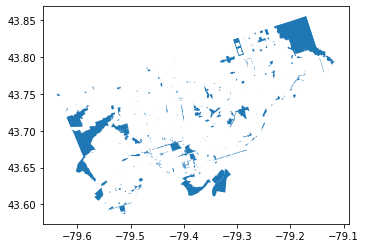

In [34]:
site_and_area_specific_policy_gdf.plot()

In [35]:
gdf_6 = join_reducer(gdf_5, site_and_area_specific_policy_gdf)

gdf_6['Site_and_Area_Specific_Policy'].fillna(0, inplace=True)

gdf_6.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area,Site_and_Area_Specific_Policy
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0.0,1.0,0.0
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0.0,0.0,0.0
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0.0,0.0,0.0
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0.0,0.0,0.0
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1.0,0.0,0.0


## 7. Zoning

In [36]:
zipfile = "C:/Users/rorya/Desktop/Portfolio/Projects/Toronto Development Applications/data/zoning-by-law-569-2013-wgs84.zip!ZONING_ZONE_CATAGORIES_WGS84.shp"
zbl = gpd.read_file(zipfile)
zbl

,OBJECTID,GEN_ZONE,ZN_ZONE,ZN_HOLDING,HOLDING_ID,FRONTAGE,ZN_AREA,UNITS,DENSITY,COVERAGE,FSI_TOTAL,PRCNT_COMM,PRCNT_RES,PRCNT_EMMP,PRCNT_OFFC,ZN_EXCPTN,EXCEPTN_NO,STAND_SET,ZN_STATUS,ZN_STRING,AREA_UNITS,ZBL_CHAPTR,ZBL_SECTN,ZBL_EXCPTN,geometry
0,270.0,0,RD,N,0,10.5,371,0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,211,-1,3,RD (f10.5; a371) (x211),0.0,10,10.20,900.3.10(211),"POLYGON ((-79.24535 43.72392, -79.24531 43.723..."
1,263.0,0,R,N,0,0.0,0,0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,113,-1,3,R (d1.0) (x113),0.0,10,10.10,900.2.10(113),"POLYGON ((-79.40519 43.67360, -79.40535 43.673..."
2,265.0,0,RT,N,0,0.0,0,0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,20,-1,3,RT (x20),0.0,10,10.60,900.5.10(20),"POLYGON ((-79.49536 43.62329, -79.49534 43.623..."
3,268.0,0,RD,N,0,0.0,0,0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,1181,-1,2,RD (x1181),0.0,10,10.20,900.3.10(1181),"POLYGON ((-79.14890 43.79331, -79.14893 43.793..."
4,655.0,202,CR,N,0,-1.0,-1,-1,-1.0,0.0,1.0,1.0,1.0,0.0,-1.0,N,0,3,2,CR 1.0 (c1.0; r1.0) SS3,-1.0,40,40.10,None,"POLYGON ((-79.54883 43.74967, -79.55030 43.749..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16095,15954.0,4,E,N,0,-1.0,-1,-1,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,Y,318,-1,2,E 1.0 (x318),-1.0,60,60.20,900.20.10(318),"POLYGON ((-79.44496 43.73189, -79.44495 43.731..."
16096,15931.0,0,RD,N,0,0.0,0,0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,235,-1,2,RD (x235),0.0,10,10.20,900.3.10(235),"POLYGON ((-79.23968 43.75412, -79.23963 43.754..."
16097,16042.0,202,CR,N,0,-1.0,-1,-1,-1.0,0.0,2.0,0.5,2.0,0.0,-1.0,Y,1722,2,2,CR 2.0 (c0.5; r2.0) SS2 (x1722),-1.0,40,40.10,900.11.10(1722),"POLYGON ((-79.30977 43.68127, -79.30967 43.681..."
16098,15755.0,5,IS,N,0,-1.0,-1,-1,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,Y,7,-1,5,None,-1.0,80,80.40,900.33.10(7),"POLYGON ((-79.29048 43.69655, -79.29049 43.696..."


In [37]:
#Remove all rows but for zone and geometry

final_zbl_table_columns = ['ZN_ZONE','geometry']
zbl_gdf = zbl.drop(columns=[col for col in zbl if col not in final_zbl_table_columns])
zbl_gdf

,ZN_ZONE,geometry
0,RD,"POLYGON ((-79.24535 43.72392, -79.24531 43.723..."
1,R,"POLYGON ((-79.40519 43.67360, -79.40535 43.673..."
2,RT,"POLYGON ((-79.49536 43.62329, -79.49534 43.623..."
3,RD,"POLYGON ((-79.14890 43.79331, -79.14893 43.793..."
4,CR,"POLYGON ((-79.54883 43.74967, -79.55030 43.749..."
...,...,...
16095,E,"POLYGON ((-79.44496 43.73189, -79.44495 43.731..."
16096,RD,"POLYGON ((-79.23968 43.75412, -79.23963 43.754..."
16097,CR,"POLYGON ((-79.30977 43.68127, -79.30967 43.681..."
16098,IS,"POLYGON ((-79.29048 43.69655, -79.29049 43.696..."


In [38]:
#Rename zone

zbl_gdf.rename(columns={'ZN_ZONE': 'Zoning_Category'}, inplace=True)

In [39]:
#Spatial join files 

gdf_final = join_reducer(gdf_6, zbl_gdf)

gdf_final.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area,Site_and_Area_Specific_Policy,Zoning_Category
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0.0,1.0,0.0,CR
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0.0,0.0,0.0,CR
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0.0,0.0,0.0,RD
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0.0,0.0,0.0,RD
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1.0,0.0,0.0,RM


## Data Wrangling - Zoning Value Counts

In [40]:
#Check the value counts for zoning category 

gdf_final['Zoning_Category'].value_counts()

RD            590
R             323
CR            221
RM            124
E              55
RS             51
RA             43
EL             37
CRE            23
UNASSIGNED     21
TBD            11
EO              8
UT              7
EH              6
ON              5
CL              5
OR              5
IS              3
I               3
O               3
RT              3
IE              2
IPW             2
IH              2
OC              1
Name: Zoning_Category, dtype: int64

In [41]:
# Combine zoning types to their larger zoning category for the sake of reducing dimensionality

residential_keywords = ['R','RD','RS','RT','RM']

residential_apartment_keywords = ['RA','RAC']

open_space_keywords = ['O','ON','OR','OG','OM','OC']

utility_keywords = ['UT']

commercial_keywords = ['CL']

commercial_residential_keywords = ['CR']

commercial_residential_employment_keywords = ['CRE']

employment_industrial_keywords = ['EL','E','EH','EO']

institutional_keywords = ['I','IH','IE','IS','IPW']

gdf_final['Zoning_Category'] = gdf_final['Zoning_Category'].apply(lambda x: 'Residential' if x in residential_keywords
                                   else 'Residential Apartment' if x in residential_apartment_keywords
                                   else 'Open Space' if x in open_space_keywords
                                   else 'Utility and Transportation' if x in utility_keywords
                                   else 'Commercial' if x in commercial_keywords
                                   else 'Commercial Residential' if x in commercial_residential_keywords
                                   else 'Commercial Residential Employment' if x in commercial_residential_employment_keywords
                                   else 'Employment Industrial' if x in employment_industrial_keywords
                                   else 'Institutional' if x in institutional_keywords
                                   else 'Remove')

In [42]:
gdf_final.groupby(['Zoning_Category'])['Status'].value_counts(sort=False)

Zoning_Category                    Status  
Commercial                         Approved      4
                                   Denied        1
Commercial Residential             Approved    131
                                   Denied       90
Commercial Residential Employment  Approved     11
                                   Denied       12
Employment Industrial              Approved     74
                                   Denied       32
Institutional                      Approved     10
                                   Denied        2
Open Space                         Approved     12
                                   Denied        2
Remove                             Approved     26
                                   Denied       10
Residential                        Approved    732
                                   Denied      359
Residential Apartment              Approved     29
                                   Denied       14
Utility and Transportation         App

In [43]:
#Remove applications that have either a low value count or where the status is consistent across all applications

zoning_category_remove = ['Remove','Open Space','Institutional','Utility and Transportation','Commercial',
                          'Commercial Residential Employment']

gdf_final = gdf_final[gdf_final['Zoning_Category'].isin(zoning_category_remove) == False]
gdf_final.head()

,Status,Number_of_Properties,Consent,Minor Variance,Official Plan Rezoning,Site Plan Application,Latitude,Longitude,geometry,Council,Neighbourhood,Population_Density,Households_In_Core_Housing_Need,Average_Income,Secondary_Plan,Business_Improvement_Area,Site_and_Area_Specific_Policy,Zoning_Category
0,Approved,1,0,0,1,0,43.626854,-79.499656,POINT (-79.49966 43.62685),Etobicoke York Community Council,Stonegate-Queensway,3199,1715,64140,0.0,1.0,0.0,Commercial Residential
1,Approved,1,0,0,0,1,43.674647,-79.400973,POINT (-79.40097 43.67465),Toronto and East York Community Council,Annex,10863,2420,112766,0.0,0.0,0.0,Commercial Residential
2,Approved,1,1,0,0,0,43.652096,-79.547083,POINT (-79.54708 43.65210),Etobicoke York Community Council,Islington-City Centre West,2712,3470,52787,0.0,0.0,0.0,Residential
3,Approved,1,0,1,0,0,43.753666,-79.338064,POINT (-79.33806 43.75367),North York Community Council,Parkwoods-Donalda,4691,3255,42516,0.0,0.0,0.0,Residential
4,Approved,1,0,0,0,1,43.735174,-79.342838,POINT (-79.34284 43.73517),North York Community Council,Banbury-Don Mills,2775,2115,67757,1.0,0.0,0.0,Residential


In [44]:
gdf_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1461 entries, 0 to 1540
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Status                           1461 non-null   object  
 1   Number_of_Properties             1461 non-null   int64   
 2   Consent                          1461 non-null   int64   
 3   Minor Variance                   1461 non-null   int64   
 4   Official Plan Rezoning           1461 non-null   int64   
 5   Site Plan Application            1461 non-null   int64   
 6   Latitude                         1461 non-null   float64 
 7   Longitude                        1461 non-null   float64 
 8   geometry                         1461 non-null   geometry
 9   Council                          1461 non-null   object  
 10  Neighbourhood                    1461 non-null   object  
 11  Population_Density               1461 non-null   int32   
 12

In [45]:
gdf_final.to_excel('combined_files_output.xlsx')